In [1]:
import pandas as pd
import os, types
import io, requests
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Load data

In [2]:
ercot_hourly_df2 = pd.read_csv('./data/combined_load.csv')
ercot_hourly_df2 = ercot_hourly_df2.fillna(method='ffill')
ercot_hourly_df2['date_time'] = ercot_hourly_df2['Hour_Ending'].apply(lambda x: datetime.fromtimestamp(datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S%z').timestamp()))

ercot_hourly_df2 = ercot_hourly_df2.drop(['Hour_Ending'],axis=1)
ercot_hourly_df2 = ercot_hourly_df2.set_index(['date_time'])

In [3]:
ercot_hourly_describe = ercot_hourly_df2.describe()

<AxesSubplot:>

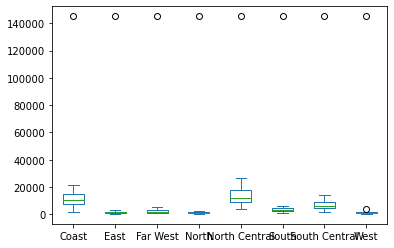

In [4]:
ercot_hourly_describe.plot.box()

In [5]:
ercot_hourly_df2[ercot_hourly_df2.isna().any(axis=1)]

,Coast,East,Far West,North,North Central,South,South Central,West
date_time,,,,,,,,


## Feature engineering of load data

In [6]:
regions = ['Coast', 'East', 'Far West', 'North', 'North Central', 'South', 'South Central', 'West']

In [7]:
starting_timestamp = '2008-07-01 00:00:00'
ending_timestamp = '2021-06-19 23:00:00'
ercot_hourly_hist = ercot_hourly_df2[pd.Timestamp(starting_timestamp):pd.Timestamp(ending_timestamp)]
starting_timestamp = '2020-06-20 00:00:00'
ending_timestamp = '2021-06-26 23:00:00'
#ercot_hourly_future = ercot_hourly_df2[pd.Timestamp(starting_timestamp):pd.Timestamp(ending_timestamp)]

In [8]:
def get_load_region(df, region):
    load_df = df[region].reset_index()
    load_df['year'] = load_df['date_time'].apply(lambda x: x.year)
    load_df['month'] = load_df['date_time'].apply(lambda x: x.month)
    load_df['day'] = load_df['date_time'].apply(lambda x: x.day)
    load_df['hour'] = load_df['date_time'].apply(lambda x: x.hour)
    #load_df['dayofyear'] = load_df['date_time'].apply(lambda x: x.dayofyear)
    #load_df['weekofyear'] = load_df['date_time'].apply(lambda x: x.weekofyear)
    load_df['weekday'] = load_df['date_time'].apply(lambda x: x.weekday())
    load_df['load'] = load_df[region]
    load_df = load_df.drop([region], axis=1)
    load_df = load_df.set_index('date_time')
    return load_df

In [9]:
for region in regions:
    load_df = get_load_region(ercot_hourly_hist, region)
    load_df.to_csv('./data/hourly_load_'+region+'.csv', index=True)

## Weather data: history and forecast

In [10]:
weather_forecast_df = pd.read_csv('./data/weather_forecast.csv')
weather_history_df = pd.read_csv('./data/weather_history.csv')

In [11]:
cities = weather_forecast_df['city'].unique()
cities

array(['Abilene', 'Austin', 'Brownsville', 'Corpus Christi', 'Dallas',
       'Houston', 'Midland', 'San Antonio', 'Tyler', 'Wichita Falls'],
      dtype=object)

In [12]:
time_dict = {0:'00:00:00', 300:'03:00:00', 600:'06:00:00', 900:'09:00:00',
             1200:'12:00:00', 1500:'15:00:00', 1800:'18:00:00', 2100:'21:00:00'}

In [13]:
def weather_data_prepare(weather_df1):
    weather_df1= weather_df1.replace({'time':time_dict})
    weather_df1['date_time'] = weather_df1['date'] + ' ' + weather_df1['time']
    weather_df1['date_time'] = pd.to_datetime(weather_df1['date_time'])
    weather_df1['temp'] = weather_df1['tempC']
    weather_df1['dwpt'] = weather_df1['DewPointC']
    weather_df1['rhum'] = weather_df1['humidity']
    weather_df1['prcp'] = weather_df1['precipMM']
    weather_df1['wspd'] = weather_df1['windspeedKmph']
    return weather_df1

In [14]:
weather_forecast_df = weather_data_prepare(weather_forecast_df)
weather_forecast_df = weather_forecast_df.set_index('date_time')
weather_history_df = weather_data_prepare(weather_history_df)
weather_history_df = weather_history_df.set_index('date_time')

### Keep most-relevant weather data

In [15]:
weather_forecast_df.drop(weather_forecast_df.columns.difference(['date_time','city','temp','dwpt','rhum','prcp','wspd']), 1, inplace=True)
weather_forecast_df

<ipython-input-15-c4596c447ff8>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  weather_forecast_df.drop(weather_forecast_df.columns.difference(['date_time','city','temp','dwpt','rhum','prcp','wspd']), 1, inplace=True)


,city,temp,dwpt,rhum,prcp,wspd
date_time,,,,,,
2021-06-20 00:00:00,Abilene,28,14,46,0.0,27
2021-06-20 00:00:00,Austin,27,21,73,0.0,15
2021-06-20 00:00:00,Brownsville,28,24,77,0.0,20
2021-06-20 00:00:00,Corpus Christi,27,23,81,0.0,16
2021-06-20 00:00:00,Dallas,29,19,58,0.0,15
...,...,...,...,...,...,...
2021-07-03 21:00:00,Houston,30,22,62,0.0,19
2021-07-03 21:00:00,Midland,34,16,41,0.6,28
2021-07-03 21:00:00,San Antonio,34,21,59,0.0,33


In [16]:
weather_history_df.drop(weather_history_df.columns.difference(['date_time','city','temp','dwpt','rhum','prcp','wspd']), 1, inplace=True)

<ipython-input-16-117b6efd70b0>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  weather_history_df.drop(weather_history_df.columns.difference(['date_time','city','temp','dwpt','rhum','prcp','wspd']), 1, inplace=True)


In [17]:
regions = ['Coast', 'East', 'Far West', 'North', 'North Central', 'South', 'South Central', 'West']
cities = ['Houston', 'Tyler', 'Midland', 'Dallas', 'Wichita Falls', 'Corpus Christi', 'San Antonio', 'Abilene']

In [18]:
def get_weather_city(df, city):
    weather_df_city = df[df['city']==city]
    weather_df_city = weather_df_city.resample("1H", origin=datetime(2008,7,1,0)).mean().interpolate('linear').ffill()
    return weather_df_city

# Get history weather data from meteostat

In [19]:
from meteostat import Point, Stations, Hourly

In [20]:
start = datetime(2008, 7, 1)
end = datetime(2021, 6, 20, 4, 0)
forecast_start = '2021-06-20 00:00:00'
forecast_end = '2021-06-26 23:00:00'

In [21]:
stations = {'Abilene':'72266', 'Austin':'72254', 'Brownsville':'72250', 'Corpus Christi':'72251', 'Dallas':'72259',
       'Houston':'72243', 'Midland':'72265', 'San Antonio':'72253', 'Tyler':'KTYR0', 'Wichita Falls':'72351'}
regions = {'Coast':'Houston', 'East':'Tyler', 'Far West':'Midland', 'North':'Wichita Falls',
           'North Central':'Dallas', 'South':'Corpus Christi', 'South Central':'San Antonio', 'West':'Abilene'}

In [22]:
def get_weather_history_forecast(staion, city, start, end):
    weather = Hourly(stations.get(city), start, end)
    weather = weather.normalize()
    weather = weather.fetch()
    weather.drop(weather.columns.difference(['time','temp','rhum','dwpt','prcp','wspd']), 1, inplace=True)
    weather = weather.fillna(method='ffill')
    weather = weather.shift(-5) # a lag is needed to match with provided weather history data.
    weather = weather.dropna()
    weather.index.name='date_time'
    # combine history and forecast weather data
    forecast = get_weather_city(weather_forecast_df, city)
    forecast = forecast[pd.Timestamp(forecast_start):pd.Timestamp(forecast_end)]
    weather = pd.concat([weather, forecast], axis=0)
    return weather

In [23]:
for city, station in stations.items():
    weather = get_weather_history_forecast(station, city, start, end)
    weather.to_csv('./data/weather_history_forecast_'+city+'.csv', index=True)

# Join load and weather data

In [24]:
for region, city in regions.items():
    load_data = pd.read_csv('./data/hourly_load_'+region+'.csv')
    #load_data = load_data.set_index('date_time')
    load_data.drop(['date_time'], axis=1, inplace=True)
    weather_data = pd.read_csv('./data/weather_history_forecast_'+city+'.csv')
    #weather_data = weather_data.set_index('date_time')
    load_weather = weather_data.join(load_data)
    #load_weather = load_weather.reset_index()
    load_weather['date_time'] = load_weather['date_time'].apply(lambda x: datetime.fromtimestamp(datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S').timestamp()))
    load_weather['year'] = load_weather['date_time'].apply(lambda x: x.year)
    load_weather['month'] = load_weather['date_time'].apply(lambda x: x.month)
    load_weather['day'] = load_weather['date_time'].apply(lambda x: x.day)
    load_weather['hour'] = load_weather['date_time'].apply(lambda x: x.hour)
    load_weather['dayofyear'] = load_weather['date_time'].apply(lambda x: x.dayofyear)
    load_weather['weekofyear'] = load_weather['date_time'].apply(lambda x: x.weekofyear)
    load_weather['weekday'] = load_weather['date_time'].apply(lambda x: x.weekday())
    load_weather = load_weather.set_index('date_time')
    load_weather.to_csv('./data/load_weather_'+region+'.csv', index=True)